In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [11]:
def json_to_df(path_or_obj):
    # Accept either a filepath (str) or already-loaded Python dict
    if isinstance(path_or_obj, str):
        with open(path_or_obj, "r", encoding="utf-8") as f:
            data = json.load(f)
    else:
        data = path_or_obj

    rows = []
    for date_str, payload in data.items():
        results = (payload or {}).get("results", {}) or {}
        for industry, info in results.items():
            rows.append({
                "date": pd.to_datetime(date_str, format="%Y%m%d", errors="coerce"),
                "industry": industry,
                "score": (info or {}).get("score")
            })

    df = pd.DataFrame(rows, columns=["date", "industry", "score"])
    df = df.dropna(subset=["date"]).sort_values(["date", "industry"]).reset_index(drop=True)
    return df

sentiments = json_to_df("/Users/edwardju/Downloads/chinese-stock-market/data/industry_sentiment.json")
tot = sentiments.groupby("date")["score"].transform(lambda s: s.abs().sum())
sentiments["tot_score"] = tot
sentiments["norm_score"] = sentiments["score"].div(tot).where(tot.ne(0))
sentiments.head()

,date,industry,score,tot_score,norm_score
0,2015-01-01,Agriculture,30,280,0.107143
1,2015-01-01,Air Transport,0,280,0.000000
2,2015-01-01,Animal Husbandry,10,280,0.035714
3,2015-01-01,Art Industry,20,280,0.071429
4,2015-01-01,Banking,0,280,0.000000


In [12]:
mean_scores = pd.DataFrame(sentiments.groupby('industry')['score'].mean().sort_values(ascending=False))
mean_scores[mean_scores.index.str.contains('Art')]

,score
industry,
Art Industry,10.01391


In [13]:
d = sentiments["date"]
s = sentiments["score"].astype(float)

n = s.groupby(d).transform("size")
k = np.ceil(0.1 * n).astype(int)

neg = s.groupby(d).rank(method="first", ascending=True) <= k
pos = s.groupby(d).rank(method="first", ascending=False) <= k

pos_den = s.where(pos, 0).groupby(d).transform("sum")
neg_den_abs = s.abs().where(neg, 0).groupby(d).transform("sum")
neg_cnt = neg.groupby(d).transform("sum")

sentiments["tail_norm"] = 0.0

# Normal: positives sum to +1 (when pos_den != 0)
pos_ok = pos & pos_den.ne(0) & s.notna()
sentiments.loc[pos_ok, "tail_norm"] = s[pos_ok] / pos_den[pos_ok]

# Normal: negatives sum to -1 via abs-weight (when neg_den_abs != 0)
neg_ok = neg & neg_den_abs.ne(0) & s.notna()
sentiments.loc[neg_ok, "tail_norm"] = -s.abs()[neg_ok] / neg_den_abs[neg_ok]

# Fallback: if selected negatives are all 0, split -1 equally across them
neg_fb = neg & neg_den_abs.eq(0) & neg_cnt.gt(0)
sentiments.loc[neg_fb, "tail_norm"] = -1.0 / neg_cnt[neg_fb]
sentiments.head()

,date,industry,score,tot_score,norm_score,tail_norm
0,2015-01-01,Agriculture,30,280,0.107143,0.150
1,2015-01-01,Air Transport,0,280,0.000000,-0.125
2,2015-01-01,Animal Husbandry,10,280,0.035714,0.000
3,2015-01-01,Art Industry,20,280,0.071429,0.100
4,2015-01-01,Banking,0,280,0.000000,-0.125


In [14]:
check = sentiments.groupby("date")["norm_score"].agg(
    pos_sum=lambda x: x[x>0].sum(),
    neg_sum=lambda x: x[x<0].sum()
)
print(check.mean())

pos_sum    0.965032
neg_sum   -0.034968
dtype: float64


In [15]:
# Raw sentiment weights (no EWMA)
def add_raw_sentiment_weights(df, col="score", date_col="date"):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col])
    
    # weight = score / sum(abs(scores)) per day
    abs_sum = d.groupby(date_col)[col].transform(lambda x: x.abs().sum())
    d["w_ls"] = d[col] / abs_sum
    d['w_ls'] = d.groupby('industry')['w_ls'].shift(1)
    d.dropna(subset=['w_ls'], inplace=True)
    return d

sentiments_decay = add_raw_sentiment_weights(sentiments, col='score')
sentiments_decay.head()

,date,industry,score,tot_score,norm_score,tail_norm,w_ls
71,2015-01-02,Agriculture,80,830,0.096386,0.235294,0.107143
72,2015-01-02,Air Transport,10,830,0.012048,0.000000,0.000000
73,2015-01-02,Animal Husbandry,20,830,0.024096,0.000000,0.035714
74,2015-01-02,Art Industry,20,830,0.024096,0.000000,0.071429
75,2015-01-02,Banking,30,830,0.036145,0.088235,0.000000


In [16]:
check = sentiments_decay.groupby("date")["w_ls"].agg(
    pos_sum=lambda x: x[x>0].sum(),
    neg_sum=lambda x: x[x<0].sum()
)
print(check.mean())

pos_sum    0.965024
neg_sum   -0.034976
dtype: float64


In [17]:
normal_sentiments = sentiments[['date', 'industry', 'norm_score']]
tail_sentiments = sentiments[['date', 'industry', 'tail_norm']]
tail_sentiments[['tail_norm']] /= 2
tail_sentiments["tail_norm_trailing"] = (
    tail_sentiments.groupby("industry")["tail_norm"]
    .transform(lambda s: s.shift(1))
)
tail_sentiments = tail_sentiments.dropna(subset=["tail_norm_trailing"]).copy()
tail_sentiments.head()

/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_15668/2797453135.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail_sentiments[['tail_norm']] /= 2
/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_15668/2797453135.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tail_sentiments["tail_norm_trailing"] = (


,date,industry,tail_norm,tail_norm_trailing
71,2015-01-02,Agriculture,0.117647,0.0750
72,2015-01-02,Air Transport,0.000000,-0.0625
73,2015-01-02,Animal Husbandry,0.000000,0.0000
74,2015-01-02,Art Industry,0.000000,0.0500
75,2015-01-02,Banking,0.044118,-0.0625


In [18]:
# Load with open and close prices for intraday calculation
daily_rets = pd.read_csv("/Users/edwardju/Downloads/CSMAR Daily Stock Return/TRD_Daily_full_20010101_20231201.csv",
                         usecols=['Stkcd', 'Trddt', 'Dsmvtll', 'Dretwd', 'Opnprc', 'Clsprc'])

# Rename columns properly (usecols doesn't preserve order, so use dict)
daily_rets = daily_rets.rename(columns={
    'Stkcd': 'stockid',
    'Trddt': 'date', 
    'Dsmvtll': 'tot_mv',
    'Dretwd': 'returns',
    'Opnprc': 'open',
    'Clsprc': 'close'
})
daily_rets['date'] = pd.to_datetime(daily_rets['date'], format='%Y-%m-%d')

# Calculate intraday return = (close - open) / open
daily_rets['intraday_ret'] = (daily_rets['close'] - daily_rets['open']) / daily_rets['open']

# merge industry
co_ind = pd.read_csv("/Users/edwardju/Downloads/CSMAR Daily Stock Return/TRD_Co.csv", encoding='cp1252', usecols=['Stkcd', 'Nindnme_en'])
co_ind.columns=['stockid', 'industry']
daily_rets = daily_rets.merge(co_ind, on=['stockid'], how='left')
daily_rets.head()

,stockid,date,open,close,tot_mv,returns,intraday_ret,industry
0,1,2016-01-04,12.00,11.33,1.621173e+08,-0.055046,-0.055833,Banking
1,1,2016-01-05,11.27,11.40,1.631189e+08,0.006178,0.011535,Banking
2,1,2016-01-06,11.42,11.53,1.649790e+08,0.011404,0.009632,Banking
3,1,2016-01-07,11.41,10.94,1.565369e+08,-0.051171,-0.041192,Banking
4,1,2016-01-08,11.21,11.12,1.591125e+08,0.016453,-0.008029,Banking


In [19]:
def make_industry_portfolios(df):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])

    df["tot_mv"] = pd.to_numeric(df["tot_mv"], errors="coerce")
    df["returns"] = pd.to_numeric(df["returns"], errors="coerce")
    df["intraday_ret"] = pd.to_numeric(df["intraday_ret"], errors="coerce")

    df["mv_x_ret"] = df["tot_mv"] * df["returns"]
    df["mv_x_intraday"] = df["tot_mv"] * df["intraday_ret"]

    out = (df.groupby(["date", "industry"], as_index=False)
            .agg(industry_tot_mv=("tot_mv", "sum"),
                mv_x_ret=("mv_x_ret", "sum"),
                mv_x_intraday=("mv_x_intraday", "sum")))

    # value-weighted industry return (close-to-close)
    out["industry_ret"] = out["mv_x_ret"].div(out["industry_tot_mv"]).where(out["industry_tot_mv"].ne(0))
    # value-weighted industry intraday return (open-to-close)
    out["industry_intraday"] = out["mv_x_intraday"].div(out["industry_tot_mv"]).where(out["industry_tot_mv"].ne(0))
    out = out[["date", "industry", "industry_ret", "industry_intraday", "industry_tot_mv"]].sort_values(["date", "industry"])
    return out

indus_portfolios = make_industry_portfolios(daily_rets)
indus_portfolios.head()

,date,industry,industry_ret,industry_intraday,industry_tot_mv
0,2001-01-02,Agriculture,0.014361,0.003847,2.786369e+07
1,2001-01-02,Air Transport,0.016456,0.012723,5.721299e+07
2,2001-01-02,Animal Husbandry,0.004651,0.004651,4.209875e+06
3,2001-01-02,Art Industry,0.015674,0.012500,2.247264e+06
4,2001-01-02,Banking,0.007063,0.006219,1.088179e+08


In [20]:
# Check industry rankings
indus_portfolios[indus_portfolios['date'] >= pd.to_datetime('2015-01-01')].groupby('industry')['industry_ret'].mean().sort_values()

industry
Oil and Gas Extraction                                                   0.000191
Forestry                                                                 0.000231
Railroad Transport                                                       0.000253
Banking                                                                  0.000326
Fishery                                                                  0.000353
                                                                           ...   
Computer Application Service                                             0.001661
Animal Husbandry                                                         0.001811
Professional and Scientific Research Services                            0.001823
Instruments and Apparatus, Culture and Office Machinery Manufacturing    0.001862
Nonmetallic Mineral Mining and Quarrying                                 0.002491
Name: industry_ret, Length: 71, dtype: float64

In [21]:
import statsmodels.api as sm

# merge with sentiments
indus_ret_senti = pd.merge(indus_portfolios, sentiments_decay, on=['date', 'industry'], how='inner')
indus_ret_senti = indus_ret_senti.sort_values(["industry","date"])

d = indus_ret_senti.copy()
# X = yesterday sentiment (raw score), y = today's return
d["score_lag1"] = d.groupby("industry")["score"].shift(1)
d = d.dropna(subset=["score_lag1","industry_ret"])

X = sm.add_constant(d["score_lag1"])
m = sm.OLS(d["industry_ret"], X).fit(cov_type="cluster", cov_kwds={"groups": d["date"]})
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:           industry_ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.2636
Date:                Thu, 11 Dec 2025   Prob (F-statistic):              0.608
Time:                        21:20:42   Log-Likelihood:             3.6299e+05
No. Observations:              153212   AIC:                        -7.260e+05
Df Residuals:                  153210   BIC:                        -7.259e+05
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.410      0.0

In [22]:
ff3 = pd.read_csv("/Users/edwardju/Downloads/CSMAR Daily Stock Return/daily_ff3_factors_total_shares_p9714.csv")
ff3['date'] = pd.to_datetime(ff3['date'], format='%Y-%m-%d')
ff3 = ff3.set_index('date')
ff3.head()

,mktrf,smb,hml
date,,,
1990-12-19,2.309671,NaN,NaN
1990-12-20,0.043263,NaN,NaN
1990-12-21,0.030616,NaN,NaN
1990-12-24,0.044825,NaN,NaN
1990-12-25,0.045802,NaN,NaN


In [23]:
print(indus_ret_senti.date.max(), indus_ret_senti.date.min())

2023-12-01 00:00:00 2015-01-05 00:00:00


Strategy Sharpe:  1.7202066482739975
Total returns:  22.889436666310385
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     1736.
Date:                Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:02:24   Log-Likelihood:                 7510.1
No. Observations:                2168   AIC:                        -1.501e+04
Df Residuals:                    2164   BIC:                        -1.499e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

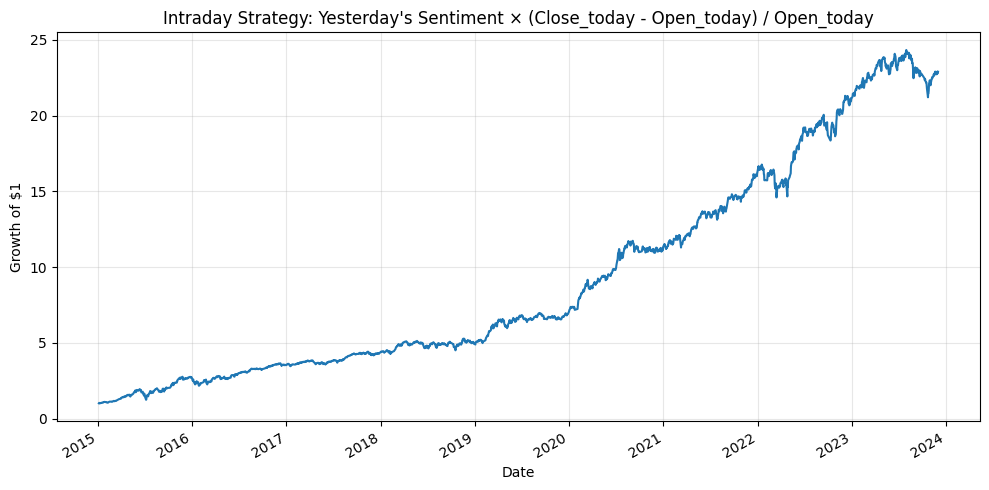

In [38]:
# Intraday Strategy: yesterday's sentiment × (close_today - open_today) / open_today

d = indus_ret_senti.copy()
d = d.dropna(subset=['industry_intraday', 'w_ls'])

sw_ret_intraday = d.groupby("date").apply(lambda g: (g['w_ls'] * g["industry_intraday"]).sum()).rename("sw_ret")

def print_stats(rets, title):
    rets = rets.sort_index().rename('ret')
    cum_rets = (1.0 + rets).cumprod().rename("cum_growth")
    print("Strategy Sharpe: ", rets.mean() / rets.std() * np.sqrt(243))
    print("Total returns: ", cum_rets.iloc[-1])
    ff = ff3.copy()
    ff = ff.merge(rets, left_index=True, right_index=True, how='inner')
    ff.dropna(subset=['ret', 'mktrf', 'smb', 'hml'], inplace=True)
    X = sm.add_constant(ff[["mktrf", 'smb', 'hml']])
    m = sm.OLS(ff['ret'], X).fit()
    print(m.summary())

    ax = cum_rets.plot(figsize=(10, 5))
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Growth of $1")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print_stats(sw_ret_intraday, "Intraday Strategy: Yesterday's Sentiment × (Close_today - Open_today) / Open_today")

Strategy Sharpe:  0.8368214738719815
Total returns:  4.670752356835448
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     5798.
Date:                Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:11:27   Log-Likelihood:                 8343.5
No. Observations:                2168   AIC:                        -1.668e+04
Df Residuals:                    2164   BIC:                        -1.666e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

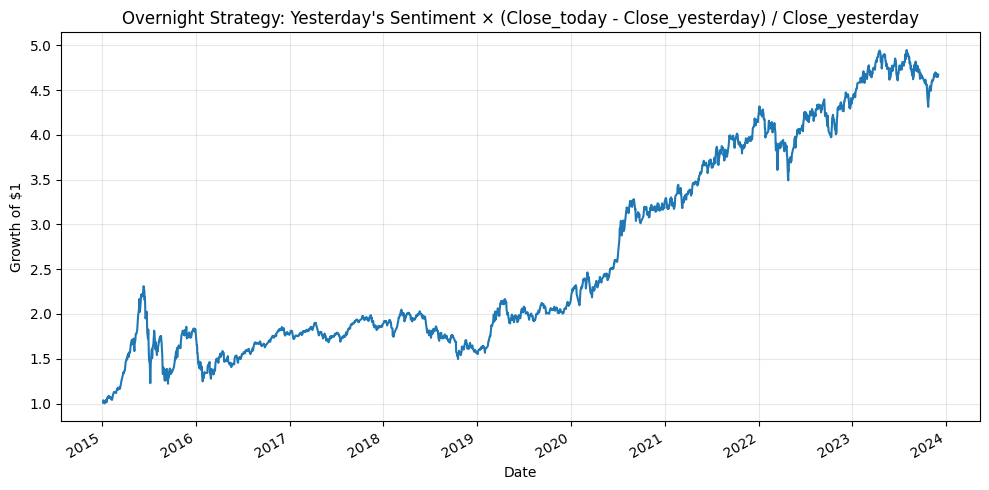

In [41]:
# Overnight Strategy: yesterday's sentiment × (close_today - close_yesterday) / close_yesterday

d = indus_ret_senti.copy()
d = d.dropna(subset=['industry_ret', 'w_ls'])

sw_ret_overnight = d.groupby("date").apply(lambda g: (g['w_ls'] * g["industry_ret"]).sum()).rename("sw_ret")
print_stats(sw_ret_overnight, "Overnight Strategy: Yesterday's Sentiment × (Close_today - Close_yesterday) / Close_yesterday")

/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_15668/1112947854.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  baseline_ret = d.groupby("date").apply(lambda g: (g["w"] * g["next_day_intraday"]).sum()).rename("baseline_ret")


Strategy Sharpe:  1.7476796506392092
Total returns:  21.159771097482658
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     2254.
Date:                Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:20:43   Log-Likelihood:                 7811.6
No. Observations:                2167   AIC:                        -1.562e+04
Df Residuals:                    2163   BIC:                        -1.559e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

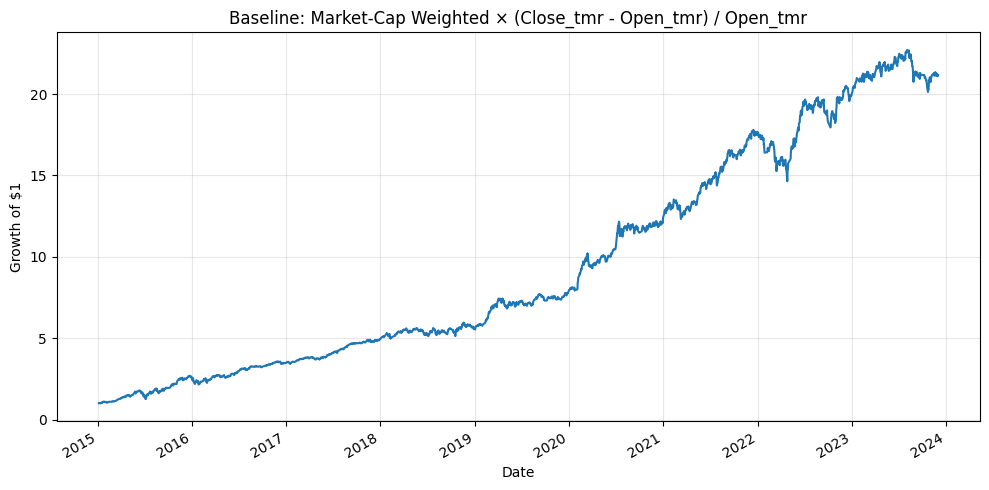

In [26]:
d = indus_ret_senti.copy()
d['next_day_intraday'] = d['industry_intraday']

d["prev_mv"] = d.groupby("industry")["industry_tot_mv"].shift(1)
d = d.dropna(subset=["prev_mv"])
d = d[d["prev_mv"] > 0]

d["day_mv"] = d.groupby("date")["prev_mv"].transform("sum")
d = d[d["day_mv"] > 0]
d["w"] = d["prev_mv"] / d["day_mv"]
d = d.dropna(subset=['next_day_intraday', 'w'])

baseline_ret = d.groupby("date").apply(lambda g: (g["w"] * g["next_day_intraday"]).sum()).rename("baseline_ret")
print_stats(baseline_ret, "Baseline: Market-Cap Weighted × (Close_tmr - Open_tmr) / Open_tmr")

/var/folders/cm/n391pt213xv2t590fn6lcrph0000gn/T/ipykernel_15668/1554057752.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  baseline_ret = d.groupby("date").apply(lambda g: (g["w"] * g["industry_ret"]).sum()).rename("baseline_ret")


Strategy Sharpe:  0.8927079999495643
Total returns:  4.988702725983588
                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.752e+05
Date:                Thu, 11 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:20:44   Log-Likelihood:                 12818.
No. Observations:                2167   AIC:                        -2.563e+04
Df Residuals:                    2163   BIC:                        -2.560e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

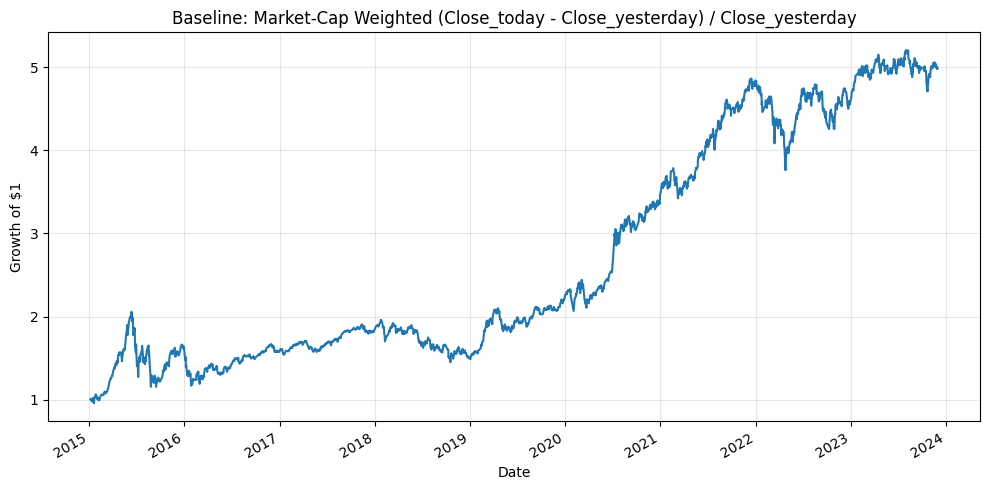

In [27]:
# baseline: Market-cap weighted (close_today - close_yesterday) / close_yesterday

baseline_ret = d.groupby("date").apply(lambda g: (g["w"] * g["industry_ret"]).sum()).rename("baseline_ret")
print_stats(baseline_ret, "Baseline: Market-Cap Weighted (Close_today - Close_yesterday) / Close_yesterday")

In [40]:
# Robustness: Sharpe by time period
import warnings
warnings.filterwarnings('ignore')

periods = [
    ("2015-2017", "2015-01-01", "2017-12-31", "crash"),
    ("2018-2019", "2018-01-01", "2019-12-31", "trade war"),
    ("2020-2021", "2020-01-01", "2021-12-31", "COVID"),
    ("2022-2023", "2022-01-01", "2023-12-31", "post-COVID"),
]

def calc_sharpe(rets):
    return rets.mean() / rets.std() * np.sqrt(243)

# prepare data for intraday strategy (w_ls already shifted in add_raw_sentiment_weights)
d_intra = indus_ret_senti.copy()
d_intra = d_intra.dropna(subset=['industry_intraday', 'w_ls'])

# prepare data for overnight strategy
d_overnight = indus_ret_senti.copy()
d_overnight = d_overnight.dropna(subset=['industry_ret', 'w_ls'])

# prepare data for baseline
d_base = indus_ret_senti.copy()
d_base["prev_mv"] = d_base.groupby("industry")["industry_tot_mv"].shift(1)
d_base = d_base.dropna(subset=["prev_mv"])
d_base = d_base[d_base["prev_mv"] > 0]
d_base["day_mv"] = d_base.groupby("date")["prev_mv"].transform("sum")
d_base = d_base[d_base["day_mv"] > 0]
d_base["w"] = d_base["prev_mv"] / d_base["day_mv"]

results = []
for name, start, end, context in periods:
    mask_intra = (d_intra['date'] >= start) & (d_intra['date'] <= end)
    mask_overnight = (d_overnight['date'] >= start) & (d_overnight['date'] <= end)
    mask_base = (d_base['date'] >= start) & (d_base['date'] <= end)
    
    ret_intra = d_intra[mask_intra].groupby("date").apply(lambda g: (g['w_ls'] * g["industry_intraday"]).sum(), include_groups=False)
    ret_overnight = d_overnight[mask_overnight].groupby("date").apply(lambda g: (g['w_ls'] * g["industry_ret"]).sum(), include_groups=False)
    ret_base_intra = d_base[mask_base].groupby("date").apply(lambda g: (g["w"] * g["industry_intraday"]).sum(), include_groups=False)
    ret_base_overnight = d_base[mask_base].groupby("date").apply(lambda g: (g["w"] * g["industry_ret"]).sum(), include_groups=False)
    
    results.append({
        'Period': name,
        'Context': context,
        'Intraday': calc_sharpe(ret_intra),
        'Overnight': calc_sharpe(ret_overnight),
        'Baseline (Intra)': calc_sharpe(ret_base_intra),
        'Baseline (Over)': calc_sharpe(ret_base_overnight)
    })

results_df = pd.DataFrame(results)
results_df = results_df.set_index('Period')
results_df[['Intraday', 'Overnight', 'Baseline (Intra)', 'Baseline (Over)']] = results_df[['Intraday', 'Overnight', 'Baseline (Intra)', 'Baseline (Over)']].round(2)
print("\nSharpe Ratio by Time Period\n")
print(results_df.to_string())


Sharpe Ratio by Time Period

              Context  Intraday  Overnight  Baseline (Intra)  Baseline (Over)
Period                                                                       
2015-2017       crash      1.80       0.81              2.07             0.82
2018-2019   trade war      1.42       0.42              1.45             0.59
2020-2021       COVID      2.73       1.95              2.48             2.11
2022-2023  post-COVID      1.22       0.41              0.70             0.18
